# Computing Stokes Coefficients
This notebook shows how to compute normalized Stokes coefficients from generic mascon models and geodesyNETs.

We use the following formal definition for the description of the gravitational potential (Tricarico 2013, Yoder 1995):

$$
U(r, \theta, \phi) = \frac \mu r \sum_{l=0}^{l=\infty}\sum_{m=0}^{m=l}\left(\frac {r_0}r\right)P_{lm}(cos\theta) \cdot\\
\cdot \left( C_{lm}\cos m\phi + S_{lm} \sin m\phi \right)
$$

where the Stokes coefficients relate to the body density via the formulas:


and

$$
C_{lm} = \frac{(2-\delta_{m,0})}{M}\frac{(l-m)!}{(l+m)!} \int_V \rho \left(\frac{r}{r_0} \right)^l \cdot\\
\cdot P_{lm}(\cos\theta)\cos m\phi dV
$$

and

$$
S_{lm} = \frac{(2-\delta_{m,0})}{M}\frac{(l-m)!}{(l+m)!} \int_V \rho \left(\frac{r}{r_0} \right)^l \cdot\\
\cdot P_{lm}(\cos\theta)\sin m\phi dV
$$

We also use the normalization factor $N_{lm}$ defined as:

$$
N_{lm} = \sqrt{\frac{(l+m)!}{(2-\delta_{m,0})(2l+1)(l-m)!} }
$$

so that our normalized Stokes coefficients are $\left\{\tilde C_{m,l}, \tilde
S_{m,l}\right\} = \left\{C_{m,l}, S_{m,l}\right\} N_{lm}$


In [1]:
# Import our module containing helper functions
import gravann

# Core imports
import numpy as np
import scipy
import pickle as pk
import os
import torchquad as tquad
tquad.set_log_level("CRITICAL")

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

C:\ProgramData\Miniconda3\envs\geodesynet\lib\site-packages\pyvista\themes.py:122: PyvistaDeprecationWarning: use "dark" instead of "night" theme
  warnings.warn('use "dark" instead of "night" theme', PyvistaDeprecationWarning)
17:54:22|TQ-INFO| Initializing torchquad.


Available devices  1
__pyTorch VERSION: 1.11.0
__CUDNN VERSION: 8200
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


# Loading and visualizing a mascon model
For the purpose of this nottebbok we will notebook we will be using, as mascon model, the one of Eros. Note though
that the procedure will be valid in general for any mascon model, that is N masses placed in N points in space.

In [3]:
# one of "eros", "bennu", "itokawa", "chryumov-gerasimenko", "planetesimal", "torus", "bennu_nu", "itokawa_nu", "planetesimal_nu"
name_of_body = "eros"

In [4]:
# We load the ground truth (a mascon model of some body)
with open("mascons/"+name_of_body+".pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
# We keep the data structure as numpy arrays (for now). Later we will use torch.
mascon_points = mascon_points
mascon_masses = mascon_masses

# Print some information on the loaded ground truth 
# (non-dimensional units assumed. All mascon coordinates are thus in -1,1 and the mass is 1)
print("Name: ", mascon_name)
print("Number of mascons: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

Name:  Eros
Number of mascons:  39554
Total mass:  1.0000000000000102


<IPython.core.display.Javascript object>


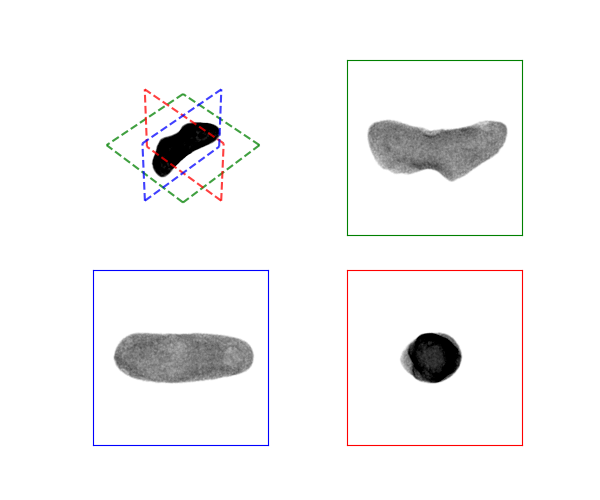

In [5]:
# Here we visualize the loaded mascon model
gravann.plot_mascon(mascon_points, mascon_masses)

# Stokes Coefficients From Mascon

In [6]:
# Units of Length (this is Eros) (depend on how the the mascon model was created .... )
# These numbers matter for the final values quantitatively (but not qualitatively)
L  = 20413.864850997925
R0 = 16000/L

In [7]:
# Let us generate all Stokes coefficients up to order 7 and degree 7 (a square model)
l=7
m=7
stokesC_gt, stokesS_gt = gravann.mascon2stokes(mascon_points, mascon_masses, R0, l, m) #-> this should go on torch?

# Stokes Coefficients from godesyNET

In [8]:
# Integrand to compute the mass
def mass(x):
    return model(x)

## We load the neural density field for Eros

In [9]:
# Encoding: direct encoding (i.e. feeding the network directly with the Cartesian coordinates in the unit hypercube)
# was found to work well in most cases. But more options are implemented in the module.
encoding = gravann.direct_encoding()

# The model is here a SIREN network (FFNN with sin non linearities and a final absolute value to predict the density)
model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = gravann.AbsLayer())
# Uncomment to run on CPU
#model.load_state_dict(torch.load("models//"+name_of_body+".mdl", map_location=torch.device('cpu')))
model.load_state_dict(torch.load("models/"+name_of_body+".mdl"))

<All keys matched successfully>

... and we initialize the quadrature object and the associated Legendre polynomials

In [10]:
# We construct the vecotrized Legendre associated polynomials
P = gravann.legendre_factory_torch(n = 16)
# Declare an integrator
quad = tquad.Trapezoid()

... we compute the Asteroid mass from the model (this corresponds to 1/c)

In [11]:
# Compute the function integral
M = quad.integrate(mass,dim=3,N=300000,integration_domain = [[-1,1],[-1,1],[-1,1]])
torch.cuda.empty_cache()

C:\ProgramData\Miniconda3\envs\geodesynet\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [32]:
stokesC_gann = np.zeros((8,8))
resC = []
for l in range(8):
    for m in range(8):
        if m>l:
            continue
        stokesC_gann[l][m] = quad.integrate(lambda x, l=l, m=m, P=P, model=model, R0=R0: gravann.Clm(x, model, l, m, R0, P), dim=3, N=310000,integration_domain =[[-1,1],[-1,1],[-1,1]])
        stokesC_gann[l][m] = stokesC_gann[l][m]/M*gravann.constant_factors(l,m)*1.001
        resC.append((f"C_{l}{m}", stokesC_gt[l][m], stokesC_gann[l][m]))
resC = sorted(resC, key = lambda x: np.abs(x[1]), reverse=True)
resC

[('C_00', 1.0000000000000102, 1.0054417848587036),
 ('C_22', 0.08766218424676277, 0.08812690526247025),
 ('C_20', -0.05280655717343416, -0.05307118594646454),
 ('C_44', 0.0195024228019579, 0.019484618678689003),
 ('C_42', -0.01814650637356026, -0.018209174275398254),
 ('C_40', 0.013044032821603378, 0.01295535359531641),
 ('C_62', 0.006580425632098485, 0.0065702819265425205),
 ('C_64', -0.0055317947824345135, -0.0058871787041425705),
 ('C_60', -0.00492049480427088, -0.004883871879428625),
 ('C_66', 0.0041220340609906415, 0.004083244130015373),
 ('C_31', 0.0033852125187556776, 0.0033991264645010233),
 ('C_33', -0.003328823747857021, -0.0033512709196656942),
 ('C_55', -0.002620362302546488, -0.0026321918703615665),
 ('C_51', -0.0024992004014617714, -0.0025134901516139507),
 ('C_53', 0.002338637203802864, 0.002335431519895792),
 ('C_32', 0.0019102204641632573, 0.0019236929947510362),
 ('C_71', 0.00165976108311893, 0.0016718279803171754),
 ('C_73', -0.0014585316632856411, -0.001486183493398

In [44]:
stokesS_gann = np.zeros((8,8))
resS = []
for l in range(8):
    for m in range(8):
        if m>l:
            continue
        stokesS_gann[l][m] = quad.integrate(lambda x, l=l, m=m, P=P, model=model, R0=R0: gravann.Slm(x, model, l, m, R0, P), dim=3, N=300000,integration_domain = [[-1,1],[-1,1],[-1,1]])
        stokesS_gann[l][m] = stokesS_gann[l][m]/M*gravann.constant_factors(l,m)
        resS.append((f"S_{l}{m}", stokesS_gt[l][m], stokesS_gann[l][m]))

resS = sorted(resS, key = lambda x: np.abs(x[1]), reverse=True)
resS

[('S_33', -0.015753745057692444, -0.01574840396642685),
 ('S_55', -0.011589346172957218, -0.011577459052205086),
 ('S_77', -0.00702503551023061, -0.006933299358934164),
 ('S_53', 0.00534620441441281, 0.005256480537354946),
 ('S_75', 0.004147675603856614, 0.004186443984508514),
 ('S_31', 0.0040338920651232174, 0.004003452602773905),
 ('S_44', 0.003464589588039252, 0.0034520248882472515),
 ('S_66', 0.003352015778219661, 0.003354698186740279),
 ('S_73', -0.002424162561036049, -0.002289918949827552),
 ('S_64', -0.0019693953082196617, -0.002045311965048313),
 ('S_51', -0.0016647437204392876, -0.0016068994300439954),
 ('S_42', -0.001278020400283566, -0.0012899840949103236),
 ('S_62', 0.0009765241481371683, 0.0009580649202689528),
 ('S_71', 0.0008044752330954282, 0.0007976962951943278),
 ('S_65', -0.0004119610796021429, -0.00040939298924058676),
 ('S_54', -0.00025975063999532507, -0.0002505839802324772),
 ('S_43', -0.0002479914936552862, -0.00031946873059496284),
 ('S_63', 0.00024238129039729

In [15]:
with open("stokes/stokes_77_eros_gt.pk", "wb") as file:
    pk.dump((stokesC_gt, stokesS_gt), file)
with open("stokes/stokes_77_eros_gann.pk", "wb") as file:
    pk.dump((stokesC_gann, stokesS_gann), file)

In [46]:
print([f"{it[0]}" for it in resS[:6]])
print([f"{it[1]:.2e}" for it in resS[:6]])
print([f"{it[2]:.2e}" for it in resS[:6]])

['S_33', 'S_55', 'S_77', 'S_53', 'S_75', 'S_31']
['-1.58e-02', '-1.16e-02', '-7.03e-03', '5.35e-03', '4.15e-03', '4.03e-03']
['-1.57e-02', '-1.16e-02', '-6.93e-03', '5.26e-03', '4.19e-03', '4.00e-03']
